# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [17]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        axes[i].imshow(image.T)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of the train data is 50000
shape of the image is torch.Size([3, 32, 32])
length of the test data is 10000
ship
cat
dog
car
truck


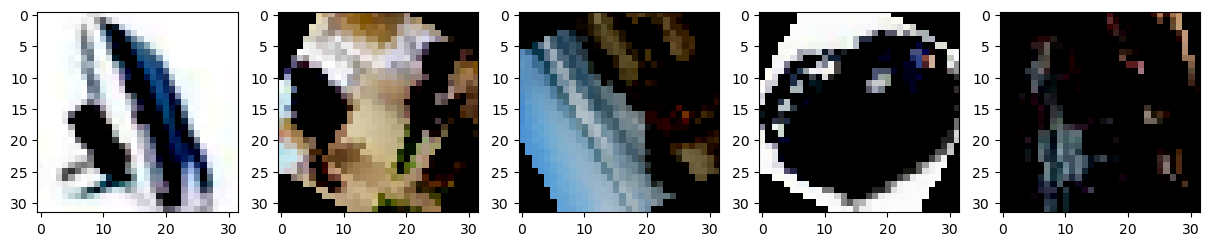

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat
ship
ship
plane
frog


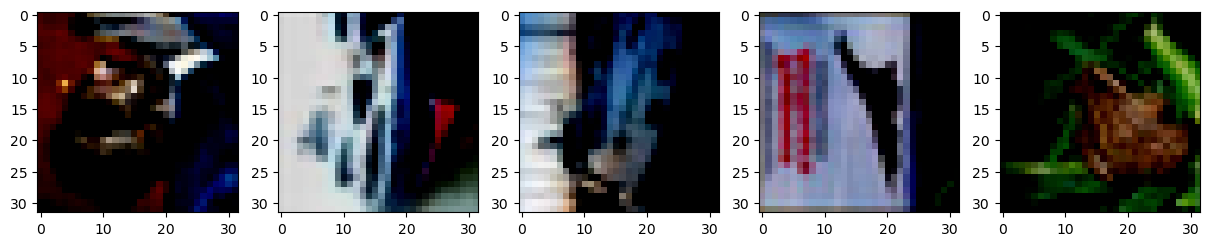

In [22]:
# Explore data
## YOUR CODE HERE ##

# length of the train data
print(f'length of the train data is {len(trainset)}')
# get sample of train data
sample = next(iter(trainset))
# get the image and it's label
image, label = sample
# view image shape
print(f'shape of the image is {image.shape}')

# length of test data
print(f'length of the test data is {len(testset)}')

show5(trainloader)
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
                      ('conv1', nn.Conv2d(3, 32, (3,3))),
                      ('relu1', nn.ReLU()),
                      ('pool1', nn.MaxPool2d(2,2)),
                      ('conv2', nn.Conv2d(32, 64, (3,3))),
                      ('relu2', nn.ReLU()),
                      ('pool2', nn.MaxPool2d(2,2)),
                      ('conv3', nn.Conv2d(64, 128, (3,3))),
                      ('relu3', nn.ReLU()),
                      ('pool3', nn.MaxPool2d(2,2)),
                      ('flatten', nn.Flatten()), 
                      ('fc1', nn.Linear(512, 128)),
                      ('relu4', nn.ReLU()),
                      ('dropout',nn.Dropout(0.5, inplace=False)),
                      ('fc2', nn.Linear(128,64)),
                      ('relu5', nn.ReLU()),
                      ('output', nn.Linear(64, 10)),
                      ('softmax', nn.LogSoftmax(dim=1))]))

model


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu5): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
## YOUR CODE HERE ##
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

epochs = 40
running_loss = 0
epoch_losses = []

for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # Move input and label tensors to the default device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_losses.append(running_loss/len(trainloader))
        
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(trainloader):.3f}.. ")
            


Epoch 1/40.. Train loss: 2.305.. 
Epoch 2/40.. Train loss: 2.302.. 
Epoch 3/40.. Train loss: 2.300.. 
Epoch 4/40.. Train loss: 2.297.. 
Epoch 5/40.. Train loss: 2.293.. 
Epoch 6/40.. Train loss: 2.285.. 
Epoch 7/40.. Train loss: 2.266.. 
Epoch 8/40.. Train loss: 2.221.. 
Epoch 9/40.. Train loss: 2.143.. 
Epoch 10/40.. Train loss: 2.071.. 
Epoch 11/40.. Train loss: 2.030.. 
Epoch 12/40.. Train loss: 1.994.. 
Epoch 13/40.. Train loss: 1.958.. 
Epoch 14/40.. Train loss: 1.917.. 
Epoch 15/40.. Train loss: 1.876.. 
Epoch 16/40.. Train loss: 1.846.. 
Epoch 17/40.. Train loss: 1.819.. 
Epoch 18/40.. Train loss: 1.791.. 
Epoch 19/40.. Train loss: 1.768.. 
Epoch 20/40.. Train loss: 1.753.. 
Epoch 21/40.. Train loss: 1.735.. 
Epoch 22/40.. Train loss: 1.719.. 
Epoch 23/40.. Train loss: 1.701.. 
Epoch 24/40.. Train loss: 1.689.. 
Epoch 25/40.. Train loss: 1.672.. 
Epoch 26/40.. Train loss: 1.658.. 
Epoch 27/40.. Train loss: 1.646.. 
Epoch 28/40.. Train loss: 1.630.. 
Epoch 29/40.. Train loss: 1.6

Plot the training loss (and validation loss/accuracy, if recorded).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


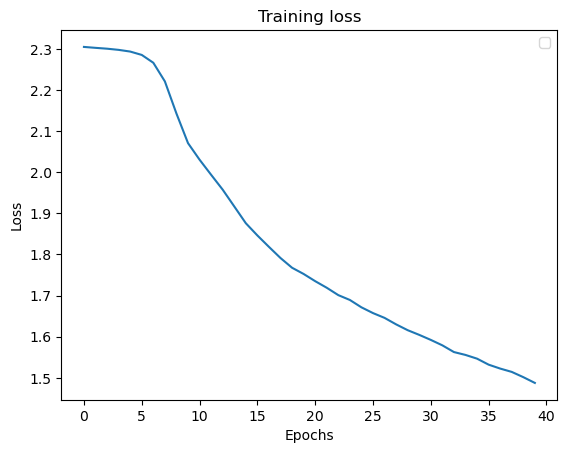

In [8]:
## YOUR CODE HERE ##
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
accuracy = 0
n_images = 0

with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        n_images += labels.size(0)

print(f'Test accuracy is {100*accuracy/n_images}%')

Test accuracy is 0.7485937476158142%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
## YOUR CODE HERE ##
checkpoint = {'model': model,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The model I built has an accuracy of 74.86% accuracy on the test set. This is much better than chance (10%). Given that Detectocorp’s algorithm has a 70% accuracy rate and we have a higher accuracy, the recommendation would be to build our own algorithm.

